# Titanic

Primeiro, lemos os arquivos e filtramos o dataset.

Aqui, removemos as colunas Name, Ticket e Cabin, já que estas
são colunas com texto que, se transformadas em número,
não vão servir para a árvore, visto que buscar um mapeamento
que transforme o texto em números de forma que estes possam ser
usados na árvore é uma tarefa com baixo custo-benefício e que não
está no escopo desta atividade.

A coluna Survived do dataset de treino foi separada,
pois nela estão os labels dos dados de treino.

In [464]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

trainDataset = pd.read_csv('train.csv')
testData = pd.read_csv('test.csv')

trainLabels = trainDataset['Survived']
trainData = trainDataset.drop(['Survived'], axis=1)

## Pré processamento

Primeiramente, buscamos analisar os dados. Queremos verificar
quais dados precisamos pré processar para que estes possam ser
processados corretamente pelo algoritmo da árvore de decisão:

In [465]:
display(trainData.head(10))

print('Tipos:')
display(trainData.dtypes)

print('Únicos:')
display(trainData.nunique())

print('Nulos:')
display(trainData.isna().sum())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Tipos:


PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Únicos:


PassengerId    891
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

Nulos:


PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Como percebemos que há valores textuais e valores nulos, buscaremos
transformar esses dados em valores numéricos, pois a árvore trabalha
apenas com valores numéricos.

Primeiramente, iremos tratar os campos sem valor definido, visto que os
algoritmos do sklearn geralmente não conseguem lidar com dados faltantes.
Para transformá-los em valores numéricos, iremos preencher os dados faltantes
em cada coluna com o valor mais frequente e com a mediana na coluna Age:

In [466]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
ageImp = SimpleImputer(missing_values=np.nan, strategy='median')

trainData.loc[:, trainData.columns != 'Age'] = imp.fit_transform(trainData.loc[:, trainData.columns != 'Age'])
trainData[['Age']] = ageImp.fit_transform(trainData[['Age']])

testData.loc[:, testData.columns != 'Age'] = imp.transform(testData.loc[:, testData.columns != 'Age'])
testData[['Age']] = ageImp.transform(testData[['Age']])

display(trainData.head(4))

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S


Para as colunas com valores textuais, as que tem um número pequeno de valores
repetidos podem ser interpretadas como classes, em que cada valor representa
uma classe diferente (como as colunas Sex e Embarked). A partir disso,
podemos mapear essas classes para valores numéricos que irão representá-las.

As outras colunas com texto deverão ser descartadas (Name, Ticket e Cabin):

In [467]:
# Retirando colunas de texto
trainData = trainData.drop(['Name', 'Ticket', 'Cabin'], axis=1)
testData = testData.drop(['Name', 'Ticket', 'Cabin'], axis=1)

# Usando OrdinalEncoder para mapear valores em Sex e Embarked para valores numéricos.
from sklearn.preprocessing import OrdinalEncoder

sexEnc = OrdinalEncoder(dtype=np.int8)
embarkEnc = OrdinalEncoder(dtype=np.int8)

sexEnc.fit(trainData[['Sex']])
embarkEnc.fit(trainData[['Embarked']])

trainData[['Sex']] = sexEnc.transform(trainData[['Sex']])
trainData[['Embarked']] = embarkEnc.transform(trainData[['Embarked']])
testData[['Sex']] = sexEnc.transform(testData[['Sex']])
testData[['Embarked']] = embarkEnc.transform(testData[['Embarked']])

display(trainData.head(4))
display(testData.head(4))

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,1,22.0,1,0,7.2500,2
1,2,1,0,38.0,1,0,71.2833,0
2,3,3,0,26.0,0,0,7.9250,2
3,4,1,0,35.0,1,0,53.1000,2


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,1,34.5,0,0,7.8292,1
1,893,3,0,47.0,1,0,7.0000,2
2,894,2,1,62.0,0,0,9.6875,1
3,895,3,1,27.0,0,0,8.6625,2


## Treinando e analisando o modelo

Agora podemos treinar o nosso modelo.

Vamos separar 10% dos dados de treino para validação do modelo
e, após isso, iremos treinar nosso modelo e validá-lo calculando
a acurácia com relação ao dataset de validação:

0.7666666666666667

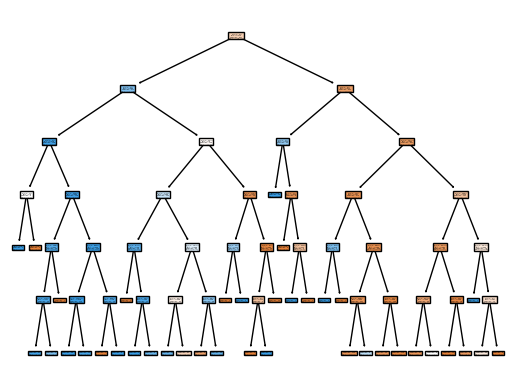

In [468]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

trainData, valData, trainLabels, valLabels = train_test_split(
    trainData, trainLabels, test_size=0.1, random_state=42
)

firstModel = tree.DecisionTreeClassifier(max_depth=6, random_state=42)
firstModel.fit(trainData, trainLabels)

tree.plot_tree(firstModel, filled=True)
display(accuracy_score(valLabels, firstModel.predict(valData)))

Agora, buscamos criar uma nova árvore considerando as
importâncias de cada característica que encontramos na árvore original.

Vamos considerar apenas as características com importância maior que 0.01:

,0,1,2,3,4,5,6,7
0,0.10663,0.136184,0.483304,0.091181,0.043943,0.006307,0.132451,0.0


0.7777777777777778

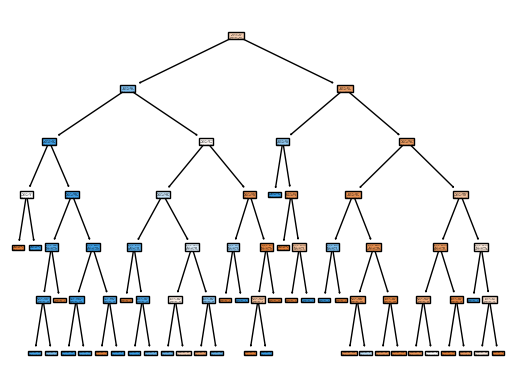

In [469]:
feats = pd.DataFrame(firstModel.feature_importances_)
display(feats.T)
idx = feats[feats[0] > 0.01].index
newTrainData = trainData.iloc[:, idx]
newValData = valData.iloc[:, idx]
newTestData = testData.iloc[:, idx]

model = tree.DecisionTreeClassifier(max_depth=6, random_state=42)
model.fit(newTrainData, trainLabels)

tree.plot_tree(model, filled=True)
display(accuracy_score(valLabels, model.predict(newValData)))

## Prevendo resultados para o dataset de teste

Agora podemos usar o nosso modelo para prever o dataset de teste
e submeter os dados de sobrevivência previstos:

In [470]:
testLabelsPredict = model.predict(newTestData)
submission = pd.DataFrame()
submission['PassengerId'] = newTestData['PassengerId']
submission['Survived'] = testLabelsPredict
display(submission.head(6))
submission.to_csv('submission.csv', index=False)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
5,897,0


Após submeter os dados para a plataforma, o score recebido foi de 0.79665.